# Lab 3 - Principal Component Analysis

Esraaj Sarkar Gupta
1st Feb, 2026

In [2]:
# ---- Imports ---- #

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

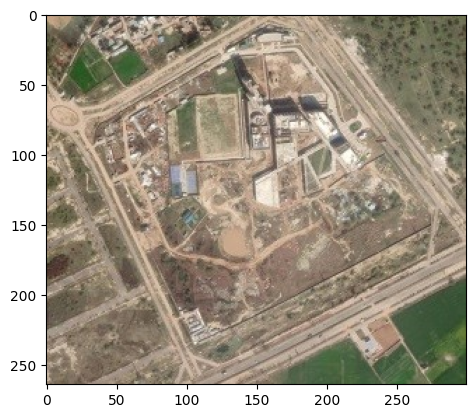

In [ ]:
# ---- Load Image ---- #

# Set image path
IMG_PATH : Path = Path (
    "sat_image_plaksha.jpg"
)

image_BGR = cv2.imread(IMG_PATH) # Default cv2 loads images as BGR, something to do with backwards compatibility and all that
image = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)

plt.imshow(image) # Looks great!

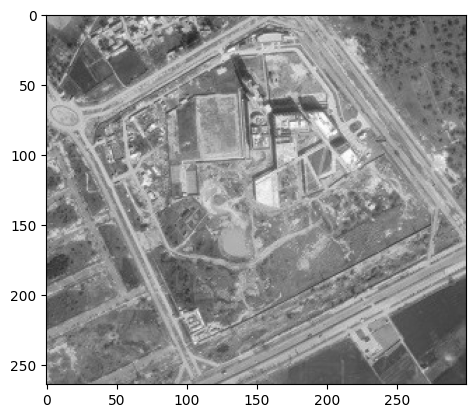

In [ ]:
# ---- Convert Image to Grayscale ---- #
"""
Reduce dimensions from 3 (RGB) to 1 (brightness)
"""

image_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Display
plt.imshow(image_bw, cmap = 'gray', vmin = 0, vmax = 255) # Restrict matplotlib cmap to gray

In [9]:
# ---- Mathematics ---- #

# Convert image to double (float64)
image_as_numbers : np.ndarray = image_bw.astype(np.float64)
print(f"Image converted to a {image_as_numbers.shape} matrix.")

# Mean centering
colomn_means : np.ndarray = np.mean(image_as_numbers, axis=0)
centered_matrix : np.ndarray = image_as_numbers - colomn_means

# Compute covmat
n = centered_matrix.shape[0] # Number of datapoints
covmat : np.ndarray = centered_matrix.T @ centered_matrix / n - 1

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(covmat) # Hermitian assumption to avoid Complex128

Image converted to a (264, 300) matrix.


In [10]:
# ---- Sort Eigenvalues and Eigenvectors ---- #

index = np.argsort(
    eigenvalues
)[::-1] # Reverse -- descending order

eigenvalues_sorted = eigenvalues[index]
eigenvectors_sorted = eigenvectors[:, index]

In [ ]:
# ---- Reconstruct Images ---- #

# Components to be tested
PRINCIPAL_COMPONENTS : int = 100
PRINCIPAL_COMPONENTS_LIST : list[int] = list([
    10,20,30,40,50,60,91,
    100,150,200             # I have included a few more values to make my figure look complete
])

# Storing the output image matrices
OUTPUT_IMAGES : list = list([])

# Main loop for PCA
for PCA_INT in PRINCIPAL_COMPONENTS_LIST:
    chosen_eigenvalues : np.ndarray = eigenvalues_sorted[:PCA_INT]
    chosen_eigenvectors : np.ndarray  = eigenvectors_sorted[:, 0:PCA_INT]

    # Linear Algebra:
    projected_img : np.ndarray = np.dot(
        chosen_eigenvectors.T, centered_matrix.T
    ).T

    new_image_centered : np.ndarray = np.dot(
        chosen_eigenvectors , projected_img.T
    ).T

    # Add means to introduce initially removed bias
    new_image = new_image_centered + colomn_means

    # Store result (my precious)
    OUTPUT_IMAGES.append(new_image)

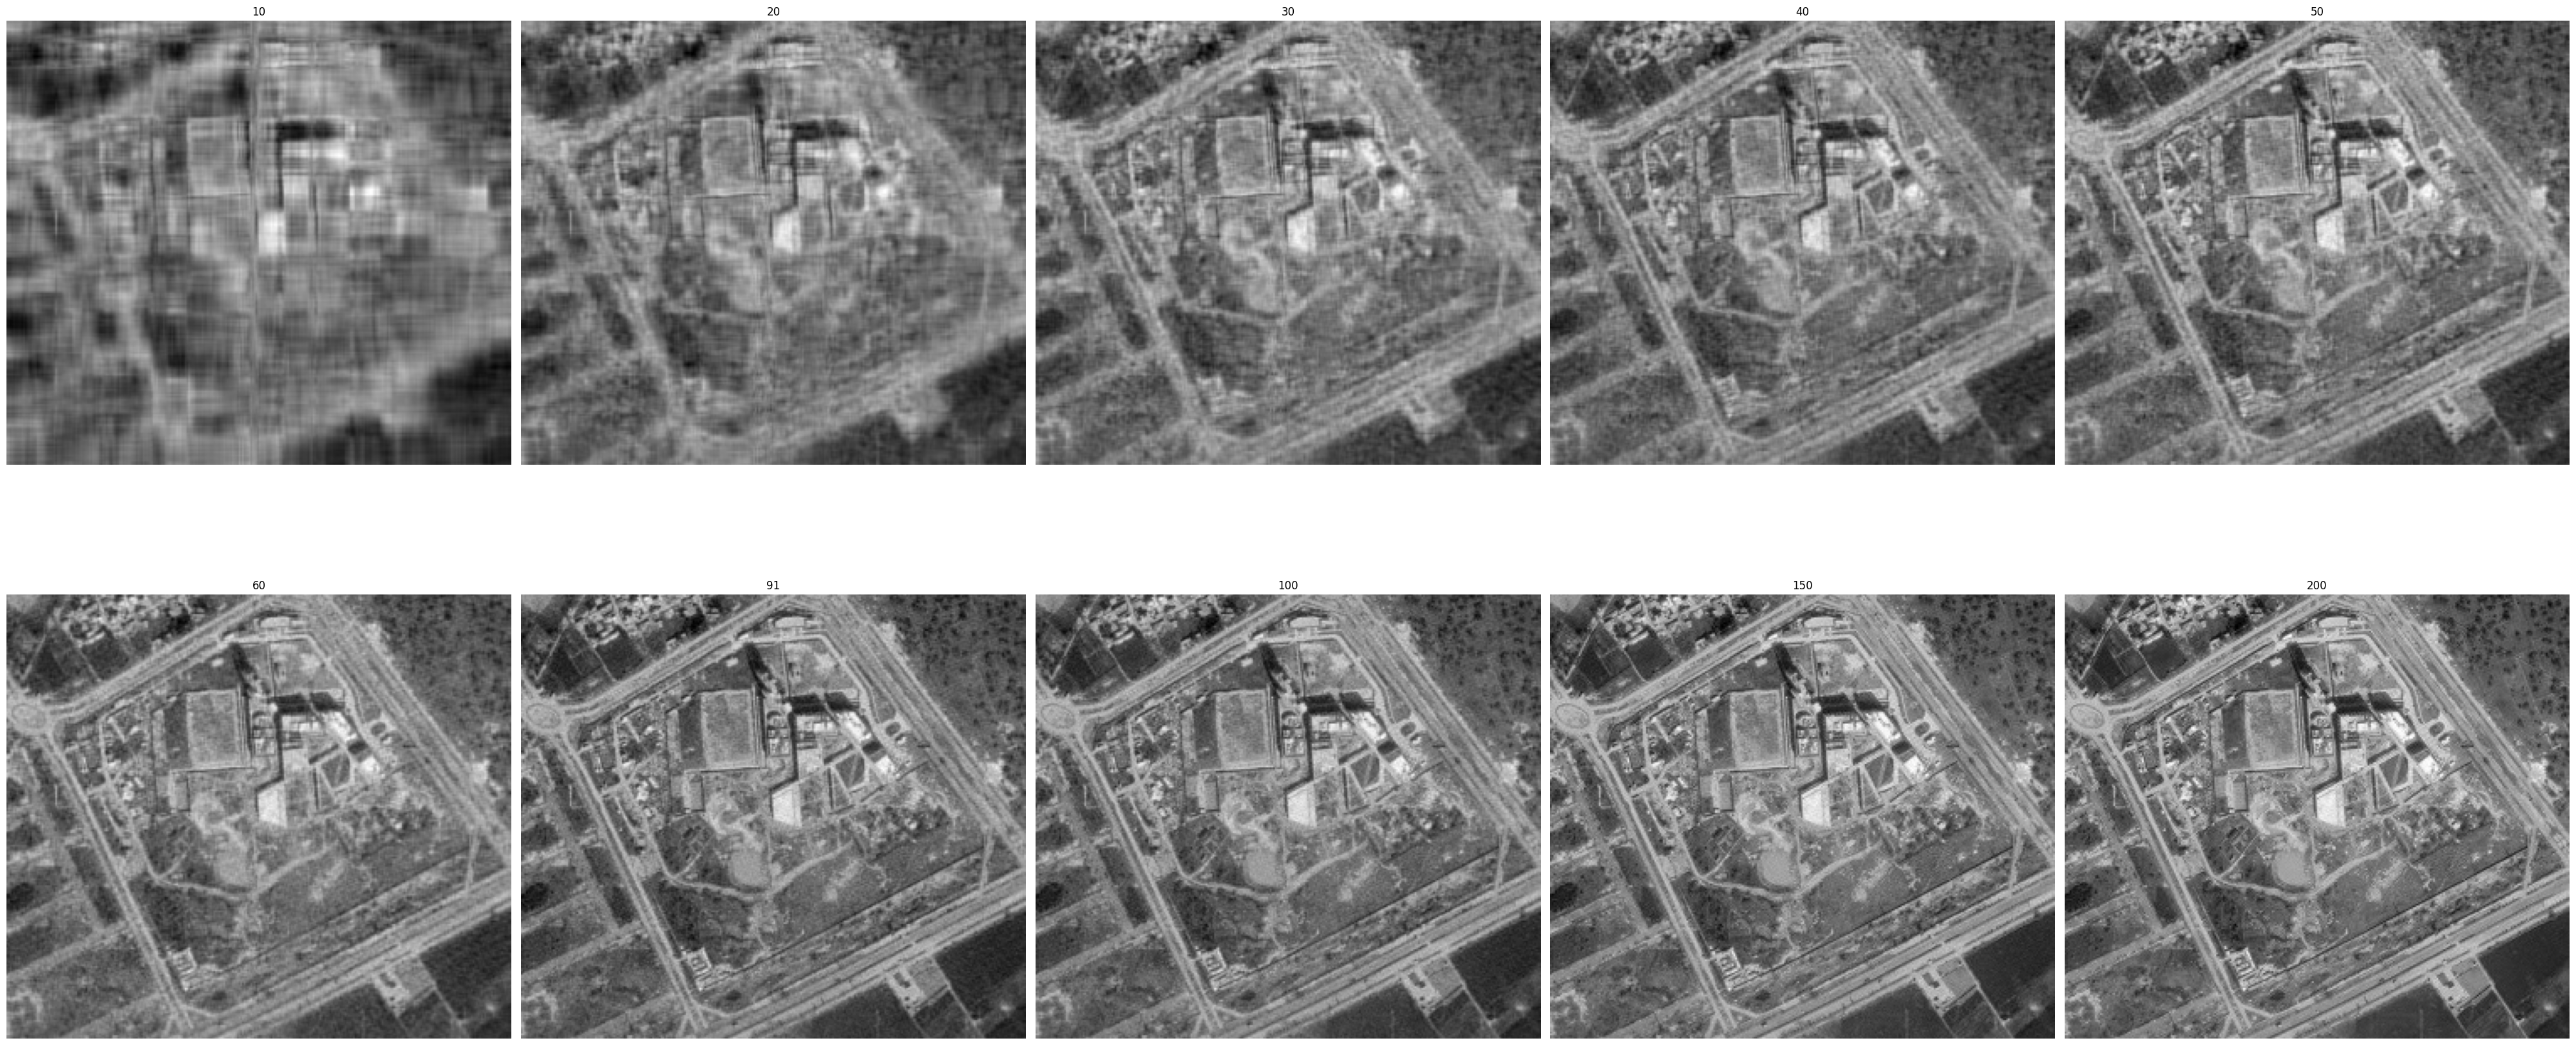

In [ ]:
# ---- Display Results ---- # 

COLS = 5
ROWS = (len(OUTPUT_IMAGES) + COLS - 1) // COLS # Ceiling division formula, I needed some help with this

# Generate the figure
fig, axes = plt.subplots(ROWS, COLS, figsize = (40,20))
axes = axes.flatten() # It's easier to iterate through single dimensions

for i,image in zip(range(len(axes)), OUTPUT_IMAGES):
    if i < len(OUTPUT_IMAGES):
        axes[i].imshow(image, cmap = 'gray')
        axes[i].set_title(f"{PRINCIPAL_COMPONENTS_LIST[i]}")
        axes[i].axis('off')
    else:
        axes[i].axis('off')
        print("If this runs I have made some sort of stupid mistake in my logic :(") # This did not run, and I am proud of myself :D

plt.tight_layout()
plt.show()

In [21]:
# ---- 95% variance ---- #

from sklearn.decomposition import PCA

compononoenents : int = 91 # As instructed
pca = PCA(n_components = compononoenents)

pca.fit(image_bw) # Fit the original image

# Check the explained variance ratio
variance_ratios = pca.explained_variance_ratio_
total_variance_explained = np.sum(variance_ratios)

var_ratios = pca.explained_variance_ratio_
total_var_explained : float = np.sum(var_ratios)

print(f"The total variance explained by {compononoenents} components is {total_var_explained:.4f}.")

The total variance explained by 91 components is 0.9506.


## Report

### Question 1

Feature selection is the process of chosing a subset of features from the set of features that make up the data. The unselected data is discarded. Data that is not discarded does not undergo any changes. PCA is fundamentally different -- the data is projected onto a new feature space (the eigenspace) and the features in this new space that explain the most variance in the data (the eigenvectors with the greatest eigenvalues) are retained, while the others are discarded. Conventionally, one retains the fewest dimensions required to explain 95% of the data.

### Question 2

PCA is very sensitive to the scale of data, since the algorithm seeks to maximise the absolute variance of the data. It is important to standardize the data (done here by creating a mean negative of the data matrix) to ensure that all correlations exhibit equal weightage in the algoritm, and so that features with greater scales or units do not dominate the algorithm.

### Question 3

The covariance (or CovMat) encodes for how each variable in the data correlates to every other datum point in the dataset. Analyzing the eigenvectors of the CovMat shows us which vectors explain the most (and least) variance. In other words, we may identify which features correlate most with each other. To minimize the number of correlated features (that act as redundant data for our ML models and increase dimensionality), we need a CovMat.

### Question 4

* PCA is limited by the assumption that the relationship between variables in data are linear. PCA fails to model complex non-linear relationships.
* PCA removes feature identities completely. One may not identify which feature contributes by how much to any ML models. Components in the post-PCA feature space are an arbitrary linear combination of all the vectors from the original feature space.
* Since PCA focuses on maximising variance, even a few outliers can severely skew the algorithm.

### Question 5

The eigenvalue of each component dictates the importance of it. The explained variance ratio of any component $a$ is determined by the equation
$$
\sigma =  \frac{\lambda_a}{\sum_i=1^n \lambda_i}.
$$

This ratio is used to determine what fraction of the total variance is explained by a single component $a$.